# A) Location Map

Using the .shp files available for the vineyard locations, we can create various visualizations to pinpoint them on a map. The first visualization will be a map displaying these locations within a region of Spain, featuring a satellitei.w.ie

To achieve this, we will need the shapefiles associated with Spain; specifically, we will use the one that contains the autonomous communities. These files can be found at the following link: https://centrodedescargas.cnig.es/CentroDescargas/limites-municipales-provinciales-autonomicos.

As a preliminary note, if you need to install any modules, you can simply run the following command:.


In [ ]:
#!pip install geopandas
#!pip install contextily
#...

### 1) We import the necessary modules and load the file.

In [5]:
import geopandas as gpd  # Import GeoPandas for working with geospatial data and shapefiles
import matplotlib.pyplot as plt  # Import Matplotlib for creating visualizations
import contextily as ctx  # Import Contextily for adding basemaps to the plots
from mpl_toolkits.axes_grid1.inset_locator import inset_axes  # Import inset_axes for creating inset maps
from matplotlib.patches import Rectangle  # Import Rectangle for adding shapes (e.g., borders) to the plots

# Load the shapefiles
vineyard_path = "ubicacion/marls_measurs.shp"  # Path to the vineyard shapefile
spain_path = "ll_autonomicas_inspire_peninbal_etrs89"  # Path to the shapefile of Spain's autonomous communities

### 2) Loading into a GeoDataFrame and Reprojecting to EPSG:3857.

In this step, we will load the data into a GeoDataFrame and reproject it to the EPSG:3857 coordinate reference system. This projection is commonly used for web mapping applications, as it provides a flat representation of the Earth's surface, making it easier to visualize geographic data on a map.

It is important to note that when recording experimental coordinates, there may be errors in the precise location that need to be corrected for accurate interpretation of the actual site. Addressing these discrepancies is crucial to ensure the reliability of the data and its subsequent analysis.

In [6]:
# Load the shapefiles into a GeoDataFrame
gdf_vineyard = gpd.read_file(vineyard_path)  
gdf_spain = gpd.read_file(spain_path) 

offset = 150  # Horizontal offset in meters
yoffset = 0  # Vertical offset in meters
gdf_vineyard['geometry'] = gdf_vineyard.geometry.translate(xoff=offset, yoff=yoffset)  # Translate geometries by the specified offsets

# If we need to apply a rotation:
rotation_angle = 35  # Rotation angle in degrees
centroid = gdf_vineyard.geometry.iloc[0].centroid  # Calculate the centroid of the first geometry
gdf_vineyard['geometry'] = gdf_vineyard.geometry.rotate(rotation_angle, origin=centroid)  # Rotate geometries around the centroid

# Reproject all shapefiles to EPSG:3857 (Web Mercator), which is compatible with basemaps
gdf_vineyard = gdf_vineyard.to_crs(epsg=3857)  
gdf_spain = gdf_spain.to_crs(epsg=3857) 

### 3) Creating and Customizing the Subfigure for the Bottom Left Corner of the Main Figure and the principal Figure.


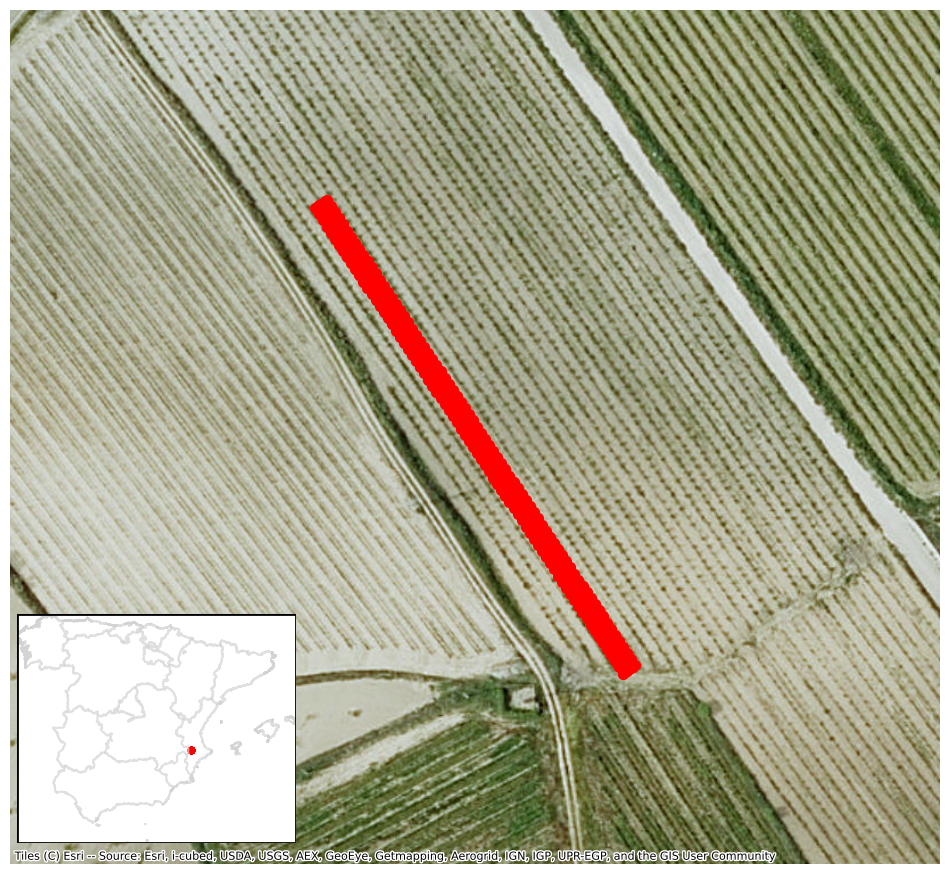

In [8]:
# Create the main figure and axes
fig, ax = plt.subplots(figsize=(12, 12))  # Create a 12x12 inch figure

# A) SUBFIGURE - INSET MAP:
# Create an inset map (small map in the bottom-left corner)
ax_inset = inset_axes(ax, width="30%", height="30%", loc="lower left")  # Add an inset map occupying 30% of the main map

# Add a solid white background to the inset map
red_background = Rectangle((0, 0), 1, 1, transform=ax_inset.transAxes, color='white', alpha=1, zorder=1)  # Add a white rectangle
ax_inset.add_patch(red_background)  # Add the rectangle to the inset map

# Add a transparent rectangle (background layer)
rect = Rectangle((0, 0), 1, 1, transform=ax_inset.transAxes, color='white', alpha=0, zorder=2)  # Add a transparent rectangle
ax_inset.add_patch(rect)  # Add the rectangle to the inset map

# Add a black border around the inset map
border = Rectangle((0, 0), 1, 1, transform=ax_inset.transAxes, edgecolor='black', facecolor='none', linewidth=2, zorder=3)  # Add a black border
ax_inset.add_patch(border)  # Add the border to the inset map

# Plot the autonomous communities shapefile on the inset map
gdf_spain.plot(ax=ax_inset, color="lightgray", edgecolor="black", alpha=0.7)  # Plot Spain's municipalities in light gray

# Add a marker for the vineyard location on the inset map
gdf_vineyard_centroid = gdf_vineyard.geometry.centroid  # Get the centroid of the vineyard geometry
gdf_vineyard_centroid.plot(ax=ax_inset, color="red", markersize=20, label="Vineyard Location")  # Plot the vineyard location on the inset map

# Adjust the visible area of the inset map to show all of Spain
xmin, ymin, xmax, ymax = gdf_spain.total_bounds  # Get the bounding box of Spain
ax_inset.set_xlim(xmin, xmax)  # Adjust the X-axis limits of the inset map
ax_inset.set_ylim(ymin, ymax)  # Adjust the Y-axis limits of the inset map

# Customize the inset map
ax_inset.axis("off")  # Hide the axes for the inset map

# B) MAIN MAP
# Plot the vineyard geometry in red on the main map
gdf_vineyard.plot(ax=ax, color="red", markersize=50, label="Vineyard")  # Highlight the vineyard in red

# Adjust the visible area of the main map to center it around the vineyard
buffer = 50  # Buffer distance in meters
xmin, ymin, xmax, ymax = gdf_vineyard.total_bounds  # Get the bounding box of the vineyard geometry
ax.set_xlim(xmin - buffer*1.6, xmax + buffer*1.6)  # Adjust the X-axis limits    
ax.set_ylim(ymin - buffer, ymax + buffer)  # Adjust the Y-axis limits

# Customize the main map
ax.axis("off")  # Hide the axes for a cleaner map

# Add a basemap to the main map (satellite imagery)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)  # Add ESRI World Imagery as the basemap

# Save the map as a PNG image 
plt.savefig("images_marls/map_marls.png", dpi=300, bbox_inches="tight") 

# Display the map
plt.show()  # Show the map

# B) Interactive Map to Locate the Vineyard Worldwide.

In this section, we will utilize Leafmap, an excellent visualization tool, to create an interactive map that allows us to pinpoint the vineyard's location on a global scale. This tool simplifies the process of geospatial analysis and enhances our ability to visualize geographic data effectivel

### 4) We import the necessary modules and create the leafmap..


In [10]:
import leafmap  # Import the Leafmap library for creating interactive maps.
import geopandas as gpd  # Import GeoPandas for working with geospatial data.
import ipywidgets as widgets  # Import ipywidgets for creating interactive widgets in Jupyter notebooks.
import pandas as pd  # Import Pandas for data manipulation and analysis.
import numpy as np  # Import NumPy for numerical operations and array handling.
import os  # Import the os module for interacting with the operating system.
from shapely.geometry import Polygon  # Import the Polygon class from Shapely for geometric operations.
from shapely.geometry.multipoint import MultiPoint  # Import the MultiPoint class for handling multiple points.

# Create a new Leafmap Map object with default settings.
m = leafmap.Map()
# Create a Leafmap Map object with specified center coordinates, zoom level, height, and disabled controls for drawing and measuring.
m = leafmap.Map(center=(40, -2), zoom=6, height="600px", draw_control=False, measure_control=False)

### 5) We store the central point of our shapefile to ubicate the center of our vineyard.

In [11]:
# List to store the points
points = []

# Load and process the shapefile
gdf = gdf_vineyard  # Read the shapefile into a GeoDataFrame

# Check and transform the coordinate reference system (CRS) to WGS84 if necessary
if gdf.crs != "EPSG:4326":
    gdf = gdf.to_crs("EPSG:4326")  # Reproject to WGS84 (EPSG:4326)

# Extract points from geometries of type Point
if gdf.geometry.geom_type.isin(['Point']).any():
    # Extract the coordinates of the points
    points2 = [point for point in gdf.geometry]

    # Create a MultiPoint object with all the points
    multipoint = MultiPoint(points2)

    # Calculate the convex hull (outer boundary) of the points
    polygon = multipoint.convex_hull

    # Create a GeoDataFrame with the polygon
    gdf_polygon = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[polygon])

    # Add the polygon to the map
    m.add_gdf(gdf_polygon, layer_name="Study Area", color='blue', fill_opacity=0.5)

    # Center the map on the polygon
    centroid = polygon.centroid
    m.set_center(lat=centroid.y, lon=centroid.x, zoom=18)
    m.add_marker(location=(centroid.y, centroid.x))

# Extract centroids from geometries of type Polygon or MultiPolygon
if gdf.geometry.geom_type.isin(['Polygon', 'MultiPolygon']).any():
    # Add the polygon to the map
    m.add_gdf(gdf, layer_name="Polygon")

    # Calculate the centroid of the polygon to center the map
    centroid = gdf.geometry.unary_union.centroid
    m.set_center(lat=centroid.y, lon=centroid.x, zoom=18)
    m.add_marker(location=(centroid.y, centroid.x))

#m.save('images_marls/map_marls.html')
m

Map(center=[38.82035428003245, -0.8139557714556779], controls=(ZoomControl(options=['position', 'zoom_in_text'…